In [ ]:
!pip install vit-keras
!pip install tensorflow-addons
!pip install keras_cv_attention_models
# Loading Drive for Colab
from google.colab import drive
from google.colab import files
import os
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import (Conv3D,Conv2D, Conv1D, MaxPooling1D, Dense, Dropout,
                          Flatten, Input, Reshape, MaxPooling2D, Activation, Lambda, multiply)
from keras_cv_attention_models import attention_layers
from tensorflow.keras import (regularizers, layers)
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import (Adam, legacy)
from keras.optimizers import Adam
from operator import truediv
from vit_keras import utils, vit
from keras.utils import to_categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.5/787.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Mounting Drive and Loading HSIs**

In [ ]:
## Loading Hyperspectral Datasets and Mounting the Colab Drive for Loading Datasets
drive.mount('/content/drive')
## Loading Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab')
    if method == 'SA':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabSalinas_corrected.mat'))['salinas_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'ColabSalinas_gt.mat'))['salinas_gt']
        Num_Classes = 16
        target_names = ['Weeds_1','Weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth', 'Stubble','Celery',
                        'Grapes_untrained','Soil_vinyard_develop','Corn_Weeds',
                        'Lettuce_4wk','Lettuce_5wk','Lettuce_6wk',
                        'Lettuce_7wk', 'Vinyard_untrained','Vinyard_trellis']
    elif method == 'IP':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabIndian_pines_corrected.mat'))['indian_pines_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'ColabIndian_pines_gt.mat'))['indian_pines_gt']
        Num_Classes = 16
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                        'Grass-pasture', 'Grass-trees', 'Grass-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings',
                        'Stone-Steel']
    elif method == 'PU':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabPaviaU.mat'))['paviaU']
        GT = sio.loadmat(os.path.join(data_path, 'ColabPaviaU_gt.mat'))['paviaU_gt']
        Num_Classes = 9
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted','Soil','Bitumen',
                        'Bricks','Shadows']
    elif method == 'PC':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabPavia.mat'))['pavia']
        GT = sio.loadmat(os.path.join(data_path, 'ColabPavia_gt.mat'))['pavia_gt']
        Num_Classes = 9
        target_names = ['Water', 'Trees', 'Asphalt', 'Bricks', 'Bitumen', 'Tiles', 'Shadows',
                        'Meadows', 'Soil']
    elif method == 'BS':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabBotswana.mat'))['Botswana']
        GT = sio.loadmat(os.path.join(data_path, 'ColabBotswana_gt.mat'))['Botswana_gt']
        Num_Classes = 14
        target_names = ['Water', 'Hippo Grass', 'Floodplain Grasses 1', 'Floodplain Grasses 2',
                        'Reeds 1', 'Riparian', 'Firescar 2', 'Island Interior', 'Woodlands',
                        'Acacia Shrublands', 'Acacia Grasslands', 'Short Mopane', 'Mixed Mopane', 'Exposed Soils']
    elif method == 'UH':
      HSI = sio.loadmat(os.path.join(data_path, 'ColabHU.mat'))['HSI']
      GT = sio.loadmat(os.path.join(data_path, 'ColabHU_gt.mat'))['gt']
      Num_Classes = 15
      target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    return HSI, GT, Num_Classes, target_names

Mounted at /content/drive


**Important Internal Functions**



In [ ]:
## Prediction Model
def PreModel(Actual, model):
  ## Validation Prediction Model
  prediction = model.predict(Actual)
  argmax_prediction = np.argmax(prediction, axis=1) + 1  # Add 1 to the argmax result to shift the class labels
  non_zero_classes = np.unique(argmax_prediction)  # Get the unique non-zero class labels
  # Remove the 0 class label if it exists in the non_zero_classes array
  if 0 in non_zero_classes:
    non_zero_classes = non_zero_classes[non_zero_classes != 0]
  # Filter out the non-zero classes from the argmax_prediction array
  Pre = argmax_prediction[np.isin(argmax_prediction, non_zero_classes)]
  return Pre

## Computing the Accuracies and Confusion Matrix for Disjoint Samples
def ClassificationReports(TeC, HSID, Te_Pre, target_names):
  classification = classification_report(np.argmax(TeC, axis=1)+1, Te_Pre, target_names = target_names)
  oa = accuracy_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  oa = round(oa, 4)
  confusion = confusion_matrix(np.argmax(TeC, axis=1)+1, Te_Pre)
  list_diag = np.diag(confusion)
  list_raw_sum = np.sum(confusion, axis=1)
  each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  aa = np.mean(each_acc)
  aa = round(aa, 4)
  kappa = cohen_kappa_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  kappa = round(kappa, 4)
  return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

## Computing the Accuracies and Confusion Matrix for Complete HSI
def ClassificationReports_HSI(TeC, HSID, Te_Pre, target_names):
  T_classification = classification_report(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1), target_names = target_names)
  T_oa = accuracy_score(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  oa = round(T_oa, 4)
  T_confusion = confusion_matrix(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  list_diag = np.diag(T_confusion)
  list_raw_sum = np.sum(T_confusion, axis=1)
  T_each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  T_aa = np.mean(T_each_acc)
  T_aa = round(T_aa, 4)
  T_kappa = cohen_kappa_score(np.argmax(TeC, axis=1), np.argmax(Te_Pre, axis=1))
  T_kappa = round(T_kappa, 4)
  return T_classification, T_confusion, T_oa*100, T_each_acc*100, T_aa*100, T_kappa*100

## Writing Results in CSV files
def CSVResults(file_name, Va_classification, Va_Confusion, Tr_Time, Va_Time,
               Te_Time, T_Time, DL_Time, Va_Kappa, Va_OA, Va_AA, Va_Per_Class,
               Te_classification, Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class,
               T_classification, T_Confusion, T_Kappa, T_OA, T_AA, T_Per_Class):
    Va_classification = str(Va_classification)
    Va_Confusion = str(Va_Confusion)
    Te_classification = str(Te_classification)
    Te_Confusion = str(Te_Confusion)
    T_classification = str(T_classification)
    T_Confusion = str(T_Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Va_Time'.format(Va_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} HSI_Time'.format(T_Time))
      CSV_file.write('\n')
      CSV_file.write('{} DL_Time'.format(DL_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Va Kappa (%)'.format(Va_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Va Overall (%)'.format(Va_OA))
      CSV_file.write('\n')
      CSV_file.write('{} VA Average (%)'.format(Va_AA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Kappa (%)'.format(Te_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Te Overall (%)'.format(Te_OA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Average (%)'.format(Te_AA))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Kappa (%)'.format(T_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Overall (%)'.format(T_OA))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Average (%)'.format(T_AA))
      CSV_file.write('\n')
      CSV_file.write('{} VA Classification'.format(Va_classification))
      CSV_file.write('\n')
      CSV_file.write('{} VA Per Class'.format(Va_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} VA Confussion'.format(Va_Confusion))
      CSV_file.write('\n')
      CSV_file.write('{} Te Classification'.format(Te_classification))
      CSV_file.write('\n')
      CSV_file.write('{} Te Per Class'.format(Te_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} Te Confussion'.format(Te_Confusion))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Classification'.format(T_classification))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Per Class'.format(T_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} HSI Confussion'.format(T_Confusion))
      CSV_file.write('\n')
    return CSV_file

**Dimensionality Reduction if Required**

In [ ]:
## Different Dimensional Reduction Methods
def DLMethod(HSI, NC = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    pca = PCA(n_components = NC, whiten = True)
    RHSI = pca.fit_transform(RHSI)
    RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
    return RHSI

**Initializating Parameters**

In [ ]:
## Global Parameters for Loop
HSID = "BS" ## "UH", "IP", "PU", "PC", "SA", "BS"
WS = 8
teRatio = 0.80
vrRatio = 0.50
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.0001, decay = 1e-06)
epochs = 50
batch_size = 56

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**3D Patch Process**

In [ ]:
## Creat Patches for 3D (Spatial-Spectral) Models
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return image_cubes, patchesLabels

**Loading HSI and Creat Patchs**

In [ ]:
## Main Function to load Datasets, Dimensional Reduction and Creating Patchs for CNN
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)

**Disjoint Train/Validation/Test Sample Selection**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

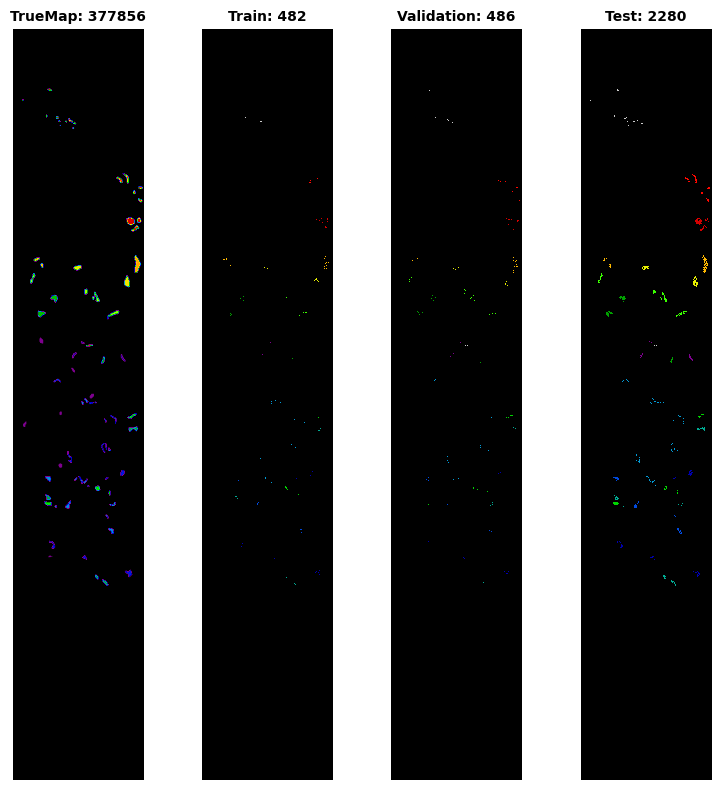

In [ ]:
## Set seed for reproducibility
np.random.seed(42)
## Calculate the number of rows for each sample
num_rows, num_cols = GT.shape
## Flatten the matrix into a 1D array
flattened = GT.flatten()
## Get the unique values and their counts, excluding the 0 class
unique_values, value_counts = np.unique(flattened, return_counts=True)
nonzero_indices = np.where(unique_values != 0)[0]
unique_values = unique_values[nonzero_indices]
## Create a DataFrame to store sample counts
Samples = pd.DataFrame(columns=['Training', 'Validation', 'Test'])
## Create lists to store the indices
TrInd = []
VaInd = []
TeInd = []
## Split the data for each class
for value in unique_values:
    class_indices = np.where(flattened == value)[0]
    train_indices, test_indices = train_test_split(class_indices, test_size=teRatio)
    train_indices, val_indices = train_test_split(train_indices, test_size=vrRatio)
    ## Save the sample counts
    Samples.loc[value] = [len(train_indices), len(val_indices), len(test_indices)]
    ## Store the indices
    TrInd.extend(train_indices)
    VaInd.extend(val_indices)
    TeInd.extend(test_indices)

## Convert the DataFrame to a CSV file
file_name = f"{HSID}_{teRatio}_{k}_{WS}_Samples.csv"
Samples.to_csv(file_name, index_label='Class')
files.download(file_name)
## Select Train/Validation/Test Samples
Tr = CRDHSI[TrInd]
Va = CRDHSI[VaInd]
Te = CRDHSI[TeInd]
## Convert labels
TrC = to_categorical(CGT[TrInd] -1)
VaC = to_categorical(CGT[VaInd] -1)
TeC = to_categorical(CGT[TeInd] -1)

**2D CNN Model**

In [ ]:
def CNN2D(WS, k, Num_Classes):
    input_layer = Input((WS, WS, k))
    conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), padding = 'same', activation='relu')(input_layer)
    conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), padding = 'same', activation='relu')(conv_layer1)
    conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), padding = 'same', activation='relu')(conv_layer2)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), padding = 'same', activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=Num_Classes, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='CNN2D')
    return model

**2D inception Net**

In [ ]:
def IN2D(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k))
    ## Block 1
    layer_1 = Conv2D(30, (1, 1), padding = 'same', activation = 'relu')(input_img)
    layer_1 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(10, (3, 3), padding = 'same', activation = 'relu')(layer_1)
    ## Block 2
    layer_2 = Conv2D(40, (1, 1), padding = 'same', activation = 'relu')(input_img)
    layer_2 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(10, (5, 5), padding = 'same', activation = 'relu')(layer_2)
    ## Block 3
    layer_3 = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(input_img)
    layer_3 = Conv2D(20, (1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(10, (1, 1), padding = 'same', activation = 'relu')(layer_3)
    ## Concatination
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    ## Convolution
    layer_4 = Conv2D(128, (1, 1), activation = 'relu')(mid_1)
    ## Classification Module
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(1200, activation = 'relu')(flat_1)
    dense_2 = Dense(600, activation = 'relu')(dense_1)
    dense_3 = Dense(150, activation = 'relu')(dense_2)
    output = Dense(Num_Classes, activation = 'softmax')(dense_3)
    ## Medel
    model = Model([input_img], output, name='IN2D')
    return model

**3D inception Net**

In [ ]:
def IN3D(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k, 1))
    ## Block 1
    layer_1 = Conv3D(30, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_1 = Conv3D(20, (3, 3, 5), padding = 'same', activation='relu')(layer_1)
    layer_1 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_1)
    ## Block 2
    layer_2 = Conv3D(40, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_2 = Conv3D(20, (3, 3, 5), padding = 'same', activation='relu')(layer_2)
    layer_2 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_2)
    ## Block 3
    layer_3 = Conv3D(60, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_3 = Conv3D(30, (3, 3, 5), padding = 'same', activation='relu')(layer_3)
    layer_3 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_3)
    ## Concatination
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    ## Convolution
    layer_4 = Conv3D(128, (1, 1, 1), activation = 'relu')(mid_1)
    ## Classification Module
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_3 = Dropout(0.4)(dense_3)
    output = Dense(Num_Classes, activation='softmax')(dense_3)
    model = Model([input_img], output, name='IN3D')
    return model

**Hybrid Inception Net**

In [ ]:
def HybIN(WS, k,Num_Classes):
    input_img = Input(shape=(WS, WS, k, 1))
    ## Block 1
    layer_1 = Conv3D(30, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_1 = Conv3D(20, (3, 3, 5), padding = 'same', activation='relu')(layer_1)
    layer_1 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_1)
    layer_1_shape = layer_1.shape
    ## 2D Structure
    layer_1 = Reshape((layer_1_shape[1], layer_1_shape[2], layer_1_shape[3]*layer_1_shape[4]))(layer_1)
    layer_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_1)
    layer_1 = Conv2D(filters = 16, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(filters = 32, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_1)
    layer_1 = Conv2D(filters = 64, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_1)
    ## Block 2
    layer_2 = Conv3D(40, (5, 5, 7), padding = 'same', activation = 'relu')(input_img)
    layer_2 = Conv3D(20, (3, 3, 5), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv3D(10, (3, 3, 3), padding = 'same', activation = 'relu')(layer_2)
    ## 2D Structure
    layer_2_shape = layer_2.shape
    layer_2 = Reshape((layer_2_shape[1], layer_2_shape[2], layer_2_shape[3]*layer_2_shape[4]))(layer_2)
    layer_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_2)
    layer_2 = Conv2D(filters = 16, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(filters = 32, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_2)
    layer_2 = Conv2D(filters = 64, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_2)
    ## Block 3
    layer_3 = Conv3D(60, (5, 5, 7), padding = 'same', activation='relu')(input_img)
    layer_3 = Conv3D(30, (3, 3, 5), padding = 'same', activation='relu')(layer_3)
    layer_3 = Conv3D(10, (3, 3, 3), padding = 'same', activation='relu')(layer_3)
    ## 2D Structure
    layer_3_shape = layer_3.shape
    layer_3 = Reshape((layer_3_shape[1], layer_3_shape[2], layer_3_shape[3]*layer_3_shape[4]))(layer_3)
    layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_3)
    layer_3 = Conv2D(filters = 16, kernel_size=(1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(filters = 32, kernel_size=(1, 1), padding = 'same', activation = 'relu')(layer_3)
    layer_3 = Conv2D(filters = 64, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_3)
    ## Concatinate
    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
    ## Convolution
    layer_4 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(mid_1)
    ## Classification Model
    flat_1 = Flatten()(layer_4)
    dense_1 = Dense(512, activation='relu')(flat_1)
    dense_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1)
    dense_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2)
    dense_3 = Dropout(0.4)(dense_3)
    output = Dense(Num_Classes, activation='softmax')(dense_3)
    ## Medel
    model = Model([input_img], output, name='HybIN')
    return model

**Hybrid CNN**

In [ ]:
def HybCNN(WS, k,Num_Classes):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), padding = 'same', activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), padding = 'same', activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(conv_layer2)
    conv3d_shape = conv_layer3.shape
    conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
    conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation = 'relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units = 128, activation = 'relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units = Num_Classes, activation = 'softmax')(dense_layer2)
    # Define the Model with Input and Output Layers
    model = Model(inputs = input_layer, outputs = output_layer, name='HybCNN')
    return model

**A Fast and Compact 3D CNN**

In [ ]:
def CNN3D(WS, k, Num_Classes):
    input_layer = Input((WS, WS, k, 1))
    conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), padding = 'same', activation='relu')(input_layer)
    conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), padding = 'same', activation='relu')(conv_layer1)
    conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(conv_layer2)
    conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(conv_layer3)
    flatten_layer = Flatten()(conv_layer4)
    dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    output_layer = Dense(units = Num_Classes, activation='softmax')(dense_layer2)
    model = Model(inputs=input_layer, outputs=output_layer, name='CNN3D')
    return model

**Attention Graph-based CNN**

In [ ]:
def AttentionGCN(WS, k, Num_Classes):
    input_layer = Input(shape=(WS, WS, k), name='input')
    conv1 = Conv2D(8, kernel_size=1, activation='relu', name='conv1', kernel_regularizer=regularizers.l2(0.0005))(input_layer)
    nn = attention_layers.cot_attention(conv1, kernel_size=3)
########## Graph-based global reasoning module # input is 8x8x8
    graph_t = Reshape((8, WS*WS))(conv1)
    squeezed_graph_t = Conv1D(16, 1, activation='relu', name='squeezer', kernel_regularizer=regularizers.l2(0.0001))(graph_t)
    squeezed_graph = Reshape((8, 16))(squeezed_graph_t)
    gconv = Conv1D(64, 1, activation='relu', name='gconv', kernel_regularizer=regularizers.l2(0.0001))(squeezed_graph)
    gconv_t = Reshape((8, 64))(gconv)
    unsqueezed_graph_transpose = Conv1D(64, 1, activation='relu', name='unsqueezer', kernel_regularizer=regularizers.l2(0.0001))(gconv_t)
    unsqueezed_graph = Reshape((64, 8))(unsqueezed_graph_transpose)
    glore = Reshape((8, WS, WS))(unsqueezed_graph)
    block1 = layers.concatenate([conv1, glore], axis=-1)
    block12 = layers.concatenate([conv1, block1, nn], axis=-1)
    conv2 = Conv2D(32, kernel_size=1, activation='relu', name='conv2', kernel_regularizer=regularizers.l2(0.0005))(block12)

# Graph-based global reasoning module 2 # input is 8x8x32
    graph_t2 = Reshape((32,WS*WS))(conv2)
    squeezed_graph_t2 = Conv1D(64, 1, activation='relu', name='squeezer2', kernel_regularizer=regularizers.l2(0.0001))(graph_t2)
    squeezed_graph2 = Reshape((64, 32))(squeezed_graph_t2)
    gconv2 = Conv1D(32, 1, activation='relu', name='gconv2', kernel_regularizer=regularizers.l2(0.0001))(squeezed_graph2)
    gconv_transpose2 = Reshape((64, 32))(gconv2)
    unsqueezed_graph_t2 = Conv1D(8*8, 1, activation='relu', name='unsqueezer2', kernel_regularizer=regularizers.l2(0.0001))(gconv_transpose2)
    unsqueezed_graph2 = Reshape((8*8, 64))(unsqueezed_graph_t2)
    glore2 = Reshape((8, 8, 64))(unsqueezed_graph2)
    block2 = layers.concatenate([conv2, glore2], axis=-1) #################  you do not need to add the feature maps of the conv2 layer
    block21 = layers.concatenate([conv2, block2, nn], axis=-1) #################  you do not need to use the feature maps of the attention block2

    conv3 = Conv2D(32, kernel_size=1, activation='relu', name='conv3', kernel_regularizer=regularizers.l2(0.0005))(block21)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', name='conv4', kernel_regularizer=regularizers.l2(0.0005))(conv3)
    conv5 = Conv2D(128, kernel_size=1, activation='relu', name='conv5', kernel_regularizer=regularizers.l2(0.0005))(conv4)

    flat = Flatten()(conv5)
    fc1 = Dense(100, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(flat)
    fc2 = Dense(20, activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.01))(fc1)
    fc3 = Dense(Num_Classes, activation='softmax', name='fc3', kernel_regularizer=regularizers.l2(0.0001))(fc2)
    model = Model(inputs=input_layer, outputs=fc3, name='AttentionGCN')
    return model

**Model Training and Evaluation**

In [ ]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam,
                             CRDHSI, HSID, teRatio, k, WS, DLM, RDHSI,
                             GT,Num_Classes,batch_size,epochs, val_matrix,
                             VaInd, test_matrix, TeInd, flattened):
  # Calling Custom Model
  model = model_name(WS, k, Num_Classes)
  model.summary()
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  # Training the model
  start = time.time()
  history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
  end = time.time()
  Tr_Time = end - start

  ## Validation Prediction Model
  start = time.time()
  Va_Pre = PreModel(Va, model)
  end = time.time()
  Va_Time = end - start

  ## Test Prediction Model
  start = time.time()
  Te_Pre = PreModel(Te, model)
  end = time.time()
  Te_Time = end - start
  ## Complete HSI Prediction Model
  start = time.time()
  T_labels = GT_Plot(CRDHSI, GT, model, WS, k)
  T_labels = T_labels.astype(int)
  end = time.time()
  T_Time = end - start

  # ## Validation Labels into GTs for Final Plot
  # Va_labels = Tranform_Labels(val_matrix, VaInd, Va_Pre)
  # ## Transform The Test Predicted Labels into GTs for Final Plot
  # Te_labels = Tranform_Labels(test_matrix, TeInd, Te_Pre)
  # ## Convert outputs to one-hot encoding for non-zero classes
  # GTA = Convert(GT, flattened)
  # GTA = GTA.astype(int)
  # # GTA = np.delete(GTA, 1, axis=1)
  # T_Predicted = Convert(GT, T_labels)
  # T_Predicted = T_Predicted.astype(int)

  ## Classification Report for Validation Model
  Va_classification,Va_Confusion,Va_OA,Va_Per_Class,Va_AA,Va_Kappa = ClassificationReports(VaC, HSID, Va_Pre, target_names)
  # Va_Kappa = round(Va_Kappa, 4)
  ## Classification Report for Test Model
  Te_classification,Te_Confusion,Te_OA,Te_Per_Class,Te_AA,Te_Kappa = ClassificationReports(TeC, HSID, Te_Pre, target_names)
  # Te_Kappa = round(Te_Kappa, 4)
  ## Classification Report for Complete HSI Model
  T_classification,T_Confusion,T_OA,T_Per_Class,T_AA,T_Kappa = ClassificationReports_HSI(GTA, HSID, T_Predicted, target_names)
  # T_Kappa = round(T_Kappa, 4)
  print(Va_classification) ## Disjoint Validation
  print(Te_classification) ## Disjoint Test
  print(T_classification)  ## Complete HSI

  ## Writing Results in CSV File
  file_name = f"{HSID}_{teRatio}_{k}_{WS}_Classification_Report_{model_name.__name__}.csv"
  CSV_file = CSVResults(file_name, Va_classification, Va_Confusion, Tr_Time, Va_Time,
                        Te_Time, T_Time, DL_Time, Va_Kappa, Va_OA, Va_AA, Va_Per_Class,
                        Te_classification, Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class,
                        T_classification, T_Confusion, T_Kappa, T_OA, T_AA, T_Per_Class)
  files.download(file_name)

  # ## Plot Ground Truths
  # cmap = 'nipy_spectral'
  # plt.figure(figsize=(8, 8))
  # plt.subplot(1, 3, 1)
  # plt.imshow(Va_labels, cmap=cmap, interpolation='nearest')
  # plt.title(f'Dis_Validation: {Va_Kappa}%', fontsize=10, fontweight='bold')
  # plt.axis('off')
  # plt.subplot(1, 3, 2)
  # plt.imshow(Te_labels, cmap=cmap, interpolation='nearest')
  # plt.title(f'Dis_Test: {Te_Kappa}%', fontsize=10, fontweight='bold')
  # plt.axis('off')
  # plt.subplot(1, 3, 3)
  # plt.imshow(T_labels, cmap=cmap, interpolation='nearest')
  # plt.title(f'Complete HSI: {T_Kappa}%', fontsize=10, fontweight='bold')
  # plt.axis('off')
  # plt.tight_layout()
  # ## Save the plot
  # file_name = f"{HSID}_{teRatio}_{k}_{WS}_Predicted_GTs_{model_name.__name__}.png"
  # plt.savefig(file_name, dpi=500)
  # files.download(file_name)
  return history, Features

**Model Training**

Model: "CNN2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 8, 8, 15)]        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 8)           1088      
                                                                 
 conv2d_42 (Conv2D)          (None, 8, 8, 16)          1168      
                                                                 
 conv2d_43 (Conv2D)          (None, 8, 8, 32)          4640      
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 flatten_10 (Flatten)        (None, 4096)              0         
                                                                 
 dense_51 (Dense)            (None, 256)               104883

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

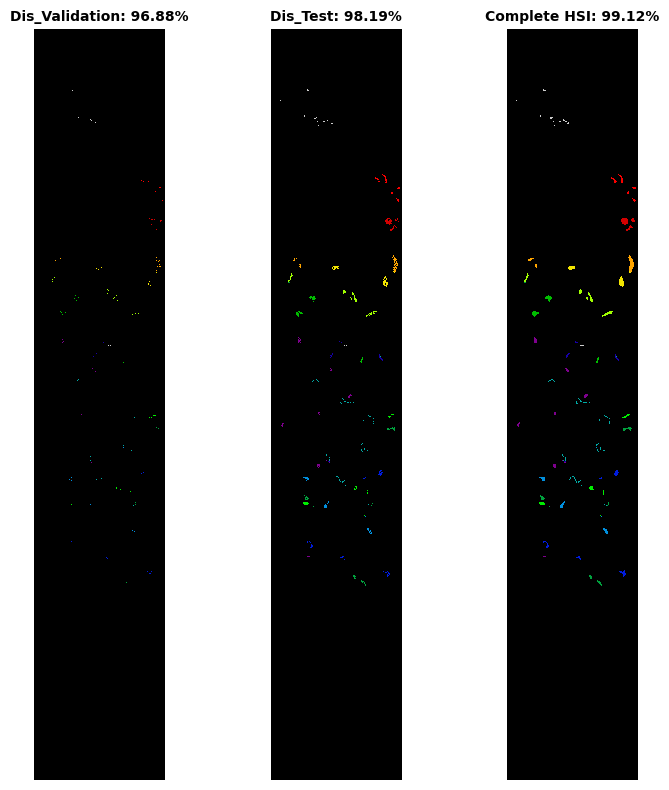

In [ ]:
# Define a list of model names
model_names = [CNN2D, IN2D, IN3D, HybIN, CNN3D, HybCNN, AttentionGCN]
# model_names = [CNN2D]
# Loop over the model names and run train_and_evaluate_model() for each model
history_list = []
Features_list = []
for model_name in model_names:
    history, Features = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC,
                                       adam, CRDHSI, HSID, teRatio, k, WS, DLM,
                                       RDHSI, GT, Num_Classes, batch_size,
                                       epochs, val_matrix, VaInd,
                                       test_matrix, TeInd, flattened)
    history_list.append(history)
    Features_list.append(Features)

**Accuracy & Loss Curves**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

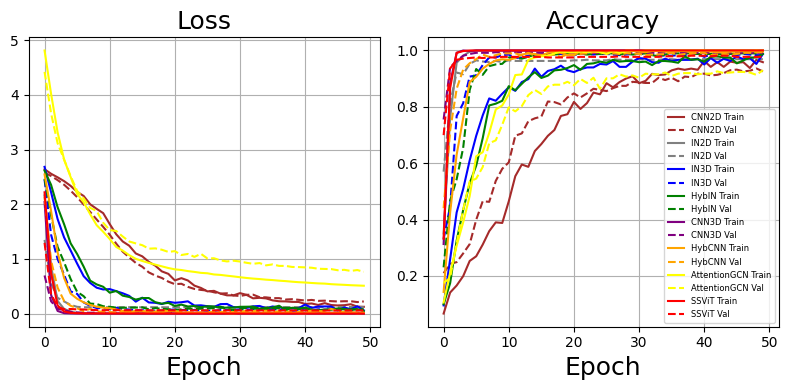

In [ ]:
# Plot training and validation loss and accuracy for each model on one graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
colors = ['brown', 'gray', 'blue', 'green', 'purple', 'orange', 'yellow', 'red']

for i, history in enumerate(history_list):
    # Plot loss
    axs[0].plot(history.history['loss'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[0].plot(history.history['val_loss'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')
    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label=f'{model_names[i].__name__} Train', color=colors[i])
    axs[1].plot(history.history['val_accuracy'], label=f'{model_names[i].__name__} Val', color=colors[i], linestyle='--')
# Add labels and legend
axs[0].set_title('Loss', fontsize=18)
axs[0].set_xlabel('Epoch', fontsize=18)
# axs[0].set_ylabel('Loss', fontsize=18)
# axs[0].legend(fontsize=18)

axs[1].set_title('Accuracy', fontsize=18)
axs[1].set_xlabel('Epoch', fontsize=18)
# axs[1].set_ylabel('Accuracy', fontsize=18)
axs[1].legend(fontsize=6)

# Add grid lines and set background color
axs[0].grid(True)
axs[1].grid(True)
# fig.patch.set_facecolor('#f2f2f2')
plt.tight_layout()
file_name = f"{HSID}_{teRatio}_{k}_{WS}_{DLM}_acc_loss_curve_all_models.png"
plt.savefig(file_name, dpi=500)
files.download(file_name)